In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('airline-passengers.csv', parse_dates=['Month'], index_col=['Month'])
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
data.index.name = 'ds'
data = data.rename(columns = {'Passengers':'y'})
data.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [6]:
data_window = one_step_forecast(data, 5)

In [7]:
class Standardize:
    def __init__(self, df, split=0.30):
        self.data = df
        self.split = split
    
    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]

In [8]:
scale_data = Standardize(data_window)
train_data, test_data, val_data = scale_data.fit_transform()

In [9]:
print(f'train: {len(train_data)} , test: {len(test_data)} , val:{len(val_data)}')

train: 69 , test: 41 , val:29


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [11]:
def features_target_pt(*args):
    y = [torch.from_numpy(col.pop('y').values.reshape(-1,1)).float() for col in args]
    x = [torch.from_numpy(col.values.reshape(*col.shape, 1)).float() for col in args]
    return *y, *x

In [12]:
(y_train_data, y_val_data, y_test_data, 
 x_train_data, x_val_data, x_test_data) = features_target_pt(train_data, val_data, test_data)

In [13]:
print(x_train_data.shape)
print(y_train_data.shape)

torch.Size([69, 5, 1])
torch.Size([69, 1])


In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

In [15]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.gru = nn.GRU(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        gru_o, hn = self.gru(x, hn)
        gru_o = self.dropout(gru_o)
        # reshape
        gru_o = gru_o.view(-1, self.hidden_dim)
        output = self.fc(gru_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden

In [42]:
def train_model_pt(model_type='LSTM', **kwargs):
    """
    Parameters:
        input_size: input size
        output_size: output size
        n_features: number of features (hidden dimension)
        n_layers: number of layers
        train_data: tuple ex (x_train, y_train)
        val_data: tuple ex (x_val, y_val)
        epochs: number of epochs
        print_every: output and history tracking
        lr: learning rate
    """

    if model_type=='LSTM':
        model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    else:
         model = GRU(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
        
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['lr'])
    
    x_train, y_train = kwargs['train_data']
    x_val, y_val  = kwargs['val_data']
    x_test, y_test = kwargs['test_data']
    
    history = {'loss': [], 'val_loss': []}
    # batch_size = x_train.shape[0]
    model.train()
    epochs = kwargs['epochs']
    print_every = kwargs['print_every']
    
    for batch_i, epoch in enumerate(range(epochs)):
        h = model.init_hidden()
        optimizer.zero_grad()
        pred, h = model(x_train, h) #model(x_train)
        #hidden = hidden.data
        loss = criterion(pred, y_train)        
        loss.backward()
        optimizer.step()
        if batch_i % print_every == 0:
            model.eval()
            with torch.no_grad():
                val_h = model.init_hidden()
                val_p, val_h = model(x_val, val_h)
                val_loss = criterion(val_p, y_val)
                history['val_loss'].append(val_loss.item())
            model.train()
            history['loss'].append(loss.item())
            print(f'{batch_i}/{epochs} - Loss:  {loss.item()}, val_loss: {val_loss.item()}')
    
    ## Prediction
    model.eval()
    with torch.no_grad():
        h0 = model.init_hidden()
        y_hat = model(x_test, h0)
    y_hat, _ = y_hat
    mse_loss_air = criterion(y_hat, y_test)
    print(f'Test MSE Loss: {mse_loss_air.item():.4f}')
    
    ## Plotting
    fig, ax = plt.subplots(2, 1) 

    ax[0].set_title(f'{model_type}: Loss and Validation Loss per epoch')
    ax[0].plot(history['loss'], 'k--', label='loss')
    ax[0].plot(history['val_loss'], 'k', label='val_loss')
    ax[0].legend()
    ax[1].set_title(f"{model_type} TEST MSE = {mse_loss_air.item():.4f}: Forecast vs Actual (Out-of-Sample data)")
    scale = kwargs['scale']
    actual = scale.inverse_y(y_test.detach().numpy().ravel())
    pred = scale.inverse_y(y_hat.detach().numpy().ravel())
    idx = kwargs['idx']
    pd.Series(actual, index=idx).plot(style='k--', label='actual', alpha=0.65)
    pd.Series(pred, index=idx).plot(style='k', label='forecast')
    fig.tight_layout()
    ax[1].legend(); plt.show()
    
    return model, history

In [55]:
params_cal = {'input_size':x_train_data.shape[1],
'output_size':1,
'units':64,
'n_layers':8,
'epochs': 500,
'print_every': 50,
'lr': 0.001,
'train_data': (x_train_data, y_train_data),
'val_data': (x_val_data, y_val_data),
'test_data': (x_test_data, y_test_data),
'idx': test_data.index,
'scale': scale_data}

0/500 - Loss:  0.9865093231201172, val_loss: 9.649759292602539
50/500 - Loss:  0.35060811042785645, val_loss: 7.487976551055908
100/500 - Loss:  0.2708519697189331, val_loss: 9.292452812194824
150/500 - Loss:  0.21620012819766998, val_loss: 9.50502872467041
200/500 - Loss:  0.18896226584911346, val_loss: 9.353705406188965
250/500 - Loss:  0.17556385695934296, val_loss: 8.658239364624023
300/500 - Loss:  0.0981888696551323, val_loss: 8.194887161254883
350/500 - Loss:  0.07222221046686172, val_loss: 8.21584415435791
400/500 - Loss:  0.0586882121860981, val_loss: 7.99655294418335
450/500 - Loss:  0.05054708942770958, val_loss: 8.326422691345215
Test MSE Loss: 20.2585


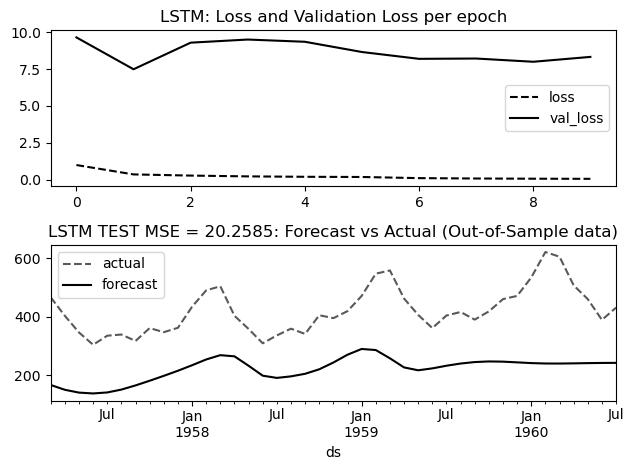

In [56]:
data_lstm, history_a_lstm = train_model_pt('LSTM', **params_cal)

In [ ]:
params_cal = {'input_size':x_train_data.shape[1],
'output_size':1,
'units':128,
'n_layers':8,
'epochs': 500,
'print_every': 50,
'lr': 0.001,
'train_data': (x_train_data, y_train_data),
'val_data': (x_val_data, y_val_data),
'test_data': (x_test_data, y_test_data),
'idx': test_data.index,
'scale': scale_data}

0/500 - Loss:  1.0017845630645752, val_loss: 9.443273544311523
50/500 - Loss:  0.15648949146270752, val_loss: 4.277095317840576
100/500 - Loss:  0.09006988257169724, val_loss: 5.7943620681762695
150/500 - Loss:  0.05195532739162445, val_loss: 8.024686813354492
200/500 - Loss:  0.04845092073082924, val_loss: 8.189815521240234
250/500 - Loss:  0.03854804486036301, val_loss: 7.863137245178223
300/500 - Loss:  0.031780485063791275, val_loss: 8.392045974731445
350/500 - Loss:  0.026698417961597443, val_loss: 8.818533897399902
400/500 - Loss:  0.023177150636911392, val_loss: 8.63057804107666
450/500 - Loss:  0.018918674439191818, val_loss: 8.156644821166992
Test MSE Loss: 24.4838


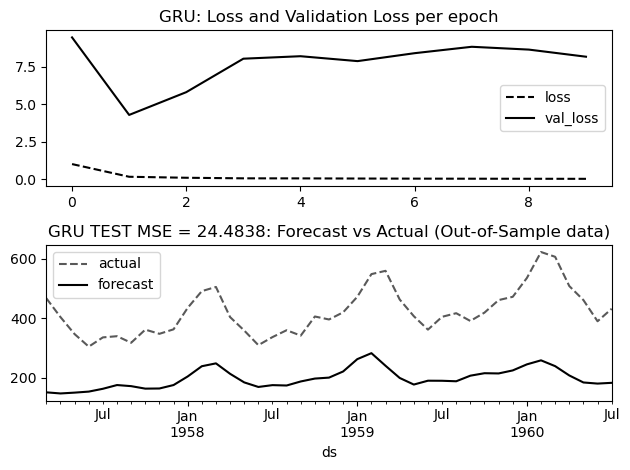

In [28]:
data_gru, history_a_gru = train_model_pt('GRU', **params_cal)